# Práctica 2 : Detección de Anomalías y Reducción de Dimensionalidad
**Statistical Learning II**

**Eddson Sierra**

Importar librerías

In [130]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

## Parte 2.1: Detección de anomalías

Aplicar detección de anomalías usando el data set de estaturas. 

In [211]:
normales = pd.read_excel(r"C:\\Users\\eddso\\OneDrive\\Maestría\\Ciclo 3 - 2021\\Statistical Learning II\\Prácticas\\Práctica 1\\estaturas.xlsx",
             sheet_name = "normales")

valtest = pd.read_excel(r"C:\\Users\\eddso\\OneDrive\\Maestría\\Ciclo 3 - 2021\\Statistical Learning II\\Prácticas\\Práctica 1\\estaturas.xlsx",
             sheet_name = "valtest(normales)")

anomalias= pd.read_excel(r"C:\\Users\\eddso\\OneDrive\\Maestría\\Ciclo 3 - 2021\\Statistical Learning II\\Prácticas\\Práctica 1\\estaturas.xlsx",
             sheet_name = "anomalias")

Podemos graficar los datos de entrenamiento y validacion:

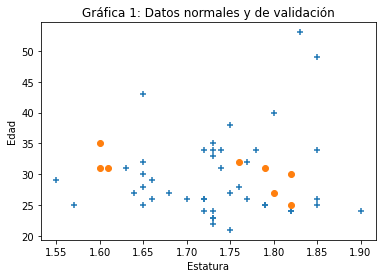

In [266]:
plt.title("Gráfica 1: Datos normales y de validación")
plt.xlabel('Estatura')
plt.ylabel('Edad')
plt.scatter(np.array(normales)[:,0],np.array(normales)[:,1], marker = '+')
plt.scatter(np.array(valtest)[:,0],np.array(valtest)[:,1], marker = 'o')
plt.show()

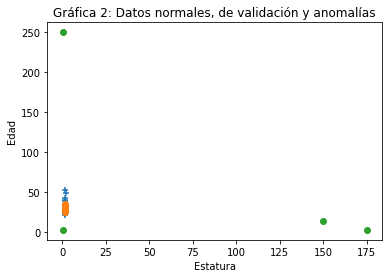

In [269]:
plt.title("Gráfica 2: Datos normales, de validación y anomalías")
plt.xlabel('Estatura')
plt.ylabel('Edad')
plt.scatter(np.array(normales)[:,0],np.array(normales)[:,1], marker = '+')
plt.scatter(np.array(valtest)[:,0],np.array(valtest)[:,1], marker = 'o')
plt.scatter(np.array(anomalias)[:,0],np.array(anomalias)[:,1])
plt.show()

Tanto en el set de validación como en el de testing, debemos añadir una columna que indique si es anomalía (y=1) o no (y=0). Esto nos servirá para evaluar el f1-score más adelante. 

In [212]:
valtest['y'] = 0
anomalias['y'] = 1

In [214]:
valtest.head(), anomalias.head()

(   Estatura(metros)  Edad(años)  y
 0              1.82          25  0
 1              1.80          27  0
 2              1.60          31  0
 3              1.60          35  0
 4              1.82          30  0,
    Estatura   Edad  y
 0      0.25    2.4  1
 1    175.10    2.5  1
 2      0.15  250.0  1
 3    150.00   14.0  1)

De valtest, usamos una mitad para cross-validation y la otra para testing.

In [215]:
norm_cross, norm_test = train_test_split(valtest, test_size = 0.5, random_state=201)
anom_cross, anom_test = train_test_split(anomalias, test_size = 0.5, random_state=201)

## Training

Usar como training set la primera pestaña "normales" (y = 0).

Creamos una función que calcula los parámetros de la distribución (media y desviación estándar):

In [185]:
# Funcion 1
def parametros_gauss(df):
    mean = np.mean(df, axis = 0)
    cov = np.cov(df.T)
    return mean, cov

Creamos una funcion que calcula la probabilidad de ocurrencia de las observaciones o PDF (Probability Density Function):

In [171]:
# Funcion 2
def pdf_gauss(df, media, matriz_cov):
    p = stats.multivariate_normal(mean=media, cov=cov)
    return p.pdf(df)

#### Paso 1:  Calculamos los parametros de la distribucion usando el train set y la funcion 1:

In [216]:
media,cov = parametros_gauss(normales)
media,cov

(Estatura(metros)     1.733864
 Edad(años)          29.590909
 dtype: float64,
 array([[5.90332981e-03, 7.69661734e-02],
        [7.69661734e-02, 4.69915433e+01]]))

#### Paso 2: Calculamos la probabilidad de ocurrencia de las observaciones en el cross-validation set y los parametros encontrados en el paso anterior. 

Usamos ese resultado dentro de una función que según el parámetro epsilon indica si es anomalía o no. Para el cross validation set debemos establecer un parámetro epsilon que permita que los datos **no sean detectados como anomalías** y que si los detecte como anomalías en el data set de anomalías.

In [218]:
pdf_gauss(norm_cross.iloc[:,0:2], media, cov)

array([0.2327378 , 0.07540928, 0.18524678, 0.11425346])

#### Paso 3: Elegimos el valor de epsilon

Para ello creamos una función que detecta las anomalías basadas en el parámetro epsilon ingresado y comparamos el resultado de la función en el cross-validation (en ambos: el que tiene anomalías y el que no tiene). 

In [260]:
def detectar_anomalia(df, epsilon):
    """
    Devuelve un arreglo con la detección de anomalías y el f1-score.
    """
    media,cov = parametros_gauss(normales)
    p = pdf_gauss(df.iloc[:,0:2], media, cov)
    print(p)
    y_estimadas = np.array([], dtype = int)
    for y in p:
        if y<epsilon:
            y_estimada = 1
            print('¡Anomalía detectada!')
        else:
            y_estimada = 0
            print('Normal')
        y_estimadas = np.append(y_estimadas, y_estimada)
    
    fs = f1_score(np.array(df.iloc[:,2]), y_estimadas, zero_division=1)
    
    return y_estimadas, fs

Observamos que utilizando un epsilon de 0.01, se detectan las 2 anomalías como tal en el data set correspondiente y todas las observaciones del cross-validation set se detectan como normales:

In [261]:
detectar_anomalia(norm_cross, 0.01)

[0.2327378  0.07540928 0.18524678 0.11425346]
Normal
Normal
Normal
Normal


(array([0, 0, 0, 0]), 1.0)

In [262]:
detectar_anomalia(anom_cross, 0.01)

[0.00000000e+00 1.59144362e-82]
¡Anomalía detectada!
¡Anomalía detectada!


(array([1, 1]), 1.0)

## Prediction

#### Paso 4: Calcular la probabilidad de que sea anomalía para los datos de prueba. 

Aplicamos la misma función, en el data set de prueba (no anomalías):

In [263]:
detectar_anomalia(norm_test, 0.01)

[0.03838091 0.06009236 0.16204119 0.27518305]
Normal
Normal
Normal
Normal


(array([0, 0, 0, 0]), 1.0)

Y en el data set de pruebas con anomalías:

In [264]:
detectar_anomalia(anom_test, 0.01)

[0. 0.]
¡Anomalía detectada!
¡Anomalía detectada!


(array([1, 1]), 1.0)

### Conclusiones de la parte 2.1

* El valor de epsilon utilizado es de 0.01 y observamos que con ese valor y una distribución multivariada Gaussiana el modelo obtiene un f1-score de 1 en todos los datos de prueba. 

* En esta práctica, el f1-score alcanzado es 1 principalmente, porque los valores anómalos se encuentran a una distancia muy grande de los valores no anómalos. Esto se puede verificar en la Gráfica no. 2. 

## Parte 2.2: Reducción de dimensionalidad

Reducir la dimensionalidad de fashion MNIST, comparando PCA con t-SNE.

In [270]:
import tensorflow as tf
from tensorflow import keras

Primero cargamos fashion MNIST:

In [291]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [302]:
train_images = train_images.reshape(60000,784)
train_images.shape

(60000, 784)

**Dimensionalidad original**

Originalmente observamos que fashion MNIST tiene 60,000 ejemplos de imágenes de prendas de ropa de 28X28 pixeles, esto significa que los datos "viven" en un espacio de 3 dimensiones. 

In [303]:
train_images.ndim

2

### PCA (manual)

#### Paso 1: Normalizar los datos

Normalizamos los datos para que tengan media = 0 y desviación igual a 1. A esta matriz normalizada le llamaremos Z. 
Para ello primero necesitamos que la matriz de datos esté de la forma **n x m**, donde m son las observaciones (60,000) y n son las variables (784). Es decir necesitamos transformar nuestra matriz original 60000 x 784 a una matriz 784 x 60000.

In [324]:
x = train_images.T
x.shape

(784, 60000)

Calculamos la media de cada variable y obtenemos un vector de medias. 

In [349]:
vector_mu = np.mean(x, axis = 1).reshape(784,1)
vector_mu.shape

(784, 1)

Calculamos la desviación estándar y obtenemos un vector con las desviaciones estándar.

In [364]:
vector_s = np.std(x, axis = 1).reshape(784,1)
vector_s.shape

(784, 1)

Ahora creamos una matrix con m copias del vector columna de las medias. 

In [367]:
matrix_mu = np.repeat(vector_mu, 60000, axis = 1)
matrix_s = np.repeat(vector_s, 60000, axis = 1)
print("Shape de matriz_mu: "+str(matrix_mu.shape))
print("Shape de matriz_s: "+str(matrix_s.shape))

Shape de matriz_mu: (784, 60000)
Shape de matriz_s: (784, 60000)


Ahora restamos la media de x y dividimos entre la desviación estándar para obtener la matriz normalizada sigma:

In [501]:
x_norm = (x - matrix_mu)/matrix_s

#### Paso 2: Calcular la matriz de covarianza

In [502]:
sigma = np.cov(x_norm, dtype = float)
sigma

array([[1.00001667, 0.32375858, 0.10472712, ..., 0.00322519, 0.00655966,
        0.03258376],
       [0.32375858, 1.00001667, 0.56275636, ..., 0.03621546, 0.02953008,
        0.02061528],
       [0.10472712, 0.56275636, 1.00001667, ..., 0.05237603, 0.02799057,
        0.02434324],
       ...,
       [0.00322519, 0.03621546, 0.05237603, ..., 1.00001667, 0.64794149,
        0.24133048],
       [0.00655966, 0.02953008, 0.02799057, ..., 0.64794149, 1.00001667,
        0.50141607],
       [0.03258376, 0.02061528, 0.02434324, ..., 0.24133048, 0.50141607,
        1.00001667]])

Observamos que la matriz de covarianza es una matriz cuadrada, positiva y simétrica:

In [503]:
sigma.shape

(784, 784)

In [552]:
sigma[0:4,0:4]

array([[1.00001667, 0.32375858, 0.10472712, 0.04516479],
       [0.32375858, 1.00001667, 0.56275636, 0.05944004],
       [0.10472712, 0.56275636, 1.00001667, 0.34216394],
       [0.04516479, 0.05944004, 0.34216394, 1.00001667]])

#### Paso 3: Calcular los eigenvectors de Z (Eigen Decomposition)

In [520]:
# se puede utilizar linalg.svd
#u, s, vh = np.linalg.svd(sigma)

In [504]:
eig_values, eig_vec = np.linalg.eig(sigma)

In [505]:
indice_orden = np.argsort(eig_values)[::-1]

eigval_ord = eig_values[indice_orden]
eigvec_ord = eig_vec[:,indice_orden]

#### Paso 4: Elegir las componentes principales. 

Para esto, primero ordenamos de forma descendente los eigenvectors de acuerdo a sus eigenvalues.

Ahora seleccionamos las primeras 2 columnas de la matriz de eigenvectors:

In [506]:
componentes = 2
matrix_reduc = eigvec_ord[:,0:componentes]
matrix_reduc.shape

(784, 2)

La varianza preservada al elegir las primeras dos componentes es del 36.50%

In [517]:
varianza_preservada = sum(eig_values[0:componentes]/np.sum(eig_values))
varianza_preservada

0.3649817991070222

#### Paso 5: Calcular la versión reducida

In [519]:
z = np.matmul(matrix_reduc.T, x)
z.shape

(2, 60000)

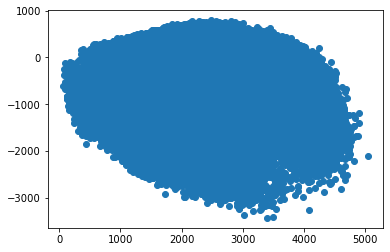

In [551]:
plt.scatter(z.T[:,0], z.T[:,1])
plt.show()

**Análisis de la representación con PCA**

La representación reducida de los datos originales ahora tiene únicamente 2 variables para 60,000 observaciones. 

Podemos observar en la representación final de las dimensiones reducidas que los datos se asemejan a una "nube". En este conjunto de datos vemos que a simple vista es difícil crear clusters. 

### t-SNE (con sklearn)

In [561]:
from sklearn.manifold import TSNE

In [567]:
x_embedded = TSNE(n_components = 2, perplexity = 50.0).fit_transform(train_images)
x_embedded.shape

(60000, 2)

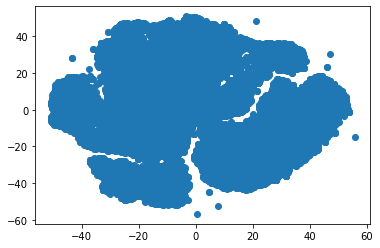

In [568]:
plt.scatter(x_embedded[:,0], x_embedded[:,1])
plt.show()

**Análisis de la representación con t-SNE**

Con este método también obtenemos la misma reducción de 784 dimensiones a 2 para las 60,000 observaciones, pero a diferencia del resultado de PCA observamos que los datos, a pesar de estar en una "nube", tienen ciertas fronteras que podrían permitir la creación de clusters. 

También podemos observar que los datos son más "simétricos" ya que están casi centrados en 0 en ambas componentes y van de -60 a 60 aproximadamente. 

### Comparación de PCA vs t-SNE y conclusión

* Al comparar el resultado de PCA vs t-SNE, salta a la vista en primer lugar, que las dimensiones obtenidas de t-SNE parecen ser más fáciles de clasificar en clusters, mientras que en PCA se generó una nube con datos difíciles de separar. 


* Una segunda diferencia es en el tiempo de ejecución. PCA es relativamente rápido con numpy, mientras que t-SNE puede tomar un tiempo considerable debido al gran tamaño del dataset. 


* Otra diferencia que se observa, es que t-SNE brinda más control sobre los resultados con el uso de hiper-parámetros que permiten ajustar los resultados. Son de importancia, el learning_rate, perplexity, número de iteraciones y n_jobs que permite definir el número de procedimientos paralelos que se ejecutan en búsqueda de vecinos.


* **Conclusión final: Finalmente, se puede afirmar que t-SNE es un algoritmo más poderoso precisamente por no ser determinístico a diferencia de Principal Component Analysis y por basarse en un procedimiento estocástico (probabilístico) para encontrar las componentes más importantes.**

## Clustering sobre la representación reducida

Ahora podemos intentar hacer cluster sobre las dimensiones reducidas con un Gaussian Mixture Model de sklearn.

In [571]:
from sklearn.mixture import GaussianMixture as GM

In [586]:
gmm_pca = GM(n_components = 10).fit(z.T)
labels_pca = gmm_pca.predict(z.T)

gmm_tsne = GM(n_components = 10).fit(x_embedded)
labels_tsne = gmm_tsne.predict(x_embedded)

**Clusters para representación reducida de PCA**

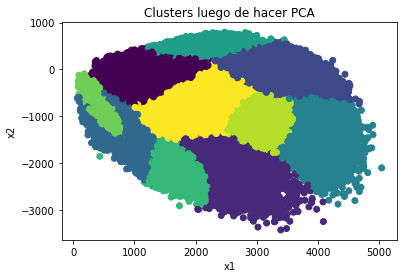

In [590]:
plt.scatter(z.T[:,0], z.T[:,1], c = labels_pca)
plt.title("Clusters luego de hacer PCA")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

**Clusters para representación reducida de t-SNE**

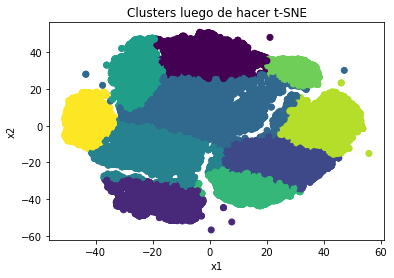

In [776]:
plt.scatter(x_embedded[:,0], x_embedded[:,1], c = labels_tsne)
plt.title("Clusters luego de hacer t-SNE")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

#### Análisis de los clusters

Analizaremos si los clusters encontrados tienden a agrupar el mismo tipo de prendas o prendas similares. Para esto, primero necesitamos crear un arreglo por cada método que tenga las observaciones, el cluster y la etiqueta correspondiente.

In [600]:
train_labels.shape

(60000,)

In [614]:
clust_pca = np.hstack((z.T,labels_pca.reshape(60000,1)))
clust_pca = np.hstack((clust_pca,train_labels.reshape(60000,1)))

clust_tsne = np.hstack((x_embedded,labels_tsne.reshape(60000,1)))
clust_tsne = np.hstack((clust_tsne, train_labels.reshape(60000,1)))

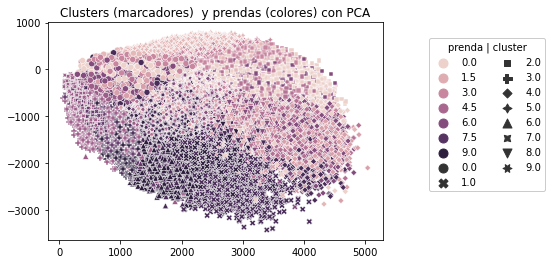

In [819]:
import seaborn as sns
plot = sns.scatterplot(x = clust_pca[:,0], y = clust_pca[:,1], style= clust_pca[:,2], hue = clust_pca[:,3])
plt.title("Clusters (marcadores)  y prendas (colores) con PCA")
plot.legend(loc="lower right", ncol = 2, markerscale = 1.5, framealpha = 1,bbox_to_anchor=(1.5, 0.2), title = "prenda | cluster")

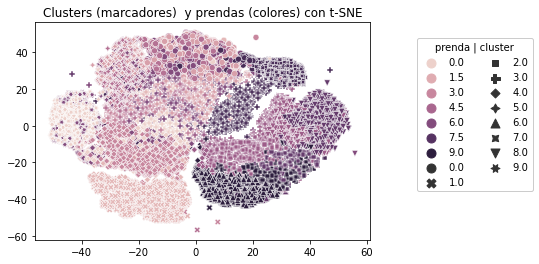

In [818]:
import seaborn as sns
plot = sns.scatterplot(x = clust_tsne[:,0], y = clust_tsne[:,1], style= clust_tsne[:,2], hue = clust_tsne[:,3])
plt.title("Clusters (marcadores)  y prendas (colores) con t-SNE")
plot.legend(loc="lower right", ncol = 2, markerscale = 1.5, framealpha = 1,bbox_to_anchor=(1.5, 0.2), title = "prenda | cluster")

Una forma exacta y más fácil de ver que prendas se están agrupando en cada cluster es crear un data frame agrupado por cluster/prenda. Para ello, creamos un dataframe y añadimos una columna del nombre de la prenda y luego añadiremos el nombre de la prenda desde un diccionario.

In [821]:
tsnedf = pd.DataFrame(clust_tsne, columns = ['comp1','comp2','cluster','prenda'])
pcadf = pd.DataFrame(clust_pca, columns = ['comp1','comp2','cluster','prenda'])

In [747]:
prendas = {0.0: 'T-shirt/top', 
           1.0: 'Trouser',
           2.0: 'Pullover',
           3.0: 'Dress',
           4.0: 'Coat',
           5.0: 'Sandal',
           6.0: 'Shirt',
           7.0: 'Sneaker', 
           8.0: 'Bag', 
           9.0: 'Ankle boot'}

In [822]:
# agrupamos por cluster y prenda en ambos dataframes:
tsnedf['nombre_prenda'] = tsnedf['prenda'].map(prendas)
g_tsne = tsnedf.groupby(by = ['cluster','prenda','nombre_prenda']).count()
g_tsne = g_tsne.drop(columns = ['comp2'])
g_tsne = g_tsne.rename(columns = {'comp1':'conteo'})

pcadf['nombre_prenda'] = pcadf['prenda'].map(prendas)
g_pca = pcadf.groupby(by = ['cluster','prenda','nombre_prenda']).count()
g_pca = g_pca.drop(columns = ['comp2'])
g_pca = g_pca.rename(columns = {'comp1':'conteo'})


Ahora podemos hacer un pivot al dataframe para visualizar todas las agrupaciones por cluster de las prendas:

**Agrupaciones de clusters y prendas para PCA**

In [824]:
table_pca = pd.pivot_table(g_pca, values='conteo', index = 'cluster',
                    columns=['prenda', 'nombre_prenda'], aggfunc=np.sum)
table_pca.fillna(0)

prenda,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
nombre_prenda,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
cluster,,,,,,,,,,
0.0,1368.0,441.0,588.0,1539.0,418.0,209.0,1187.0,3.0,296.0,14.0
1.0,21.0,5.0,69.0,2.0,44.0,31.0,89.0,10.0,2456.0,1182.0
2.0,3218.0,367.0,122.0,2249.0,830.0,0.0,874.0,0.0,15.0,0.0
3.0,6.0,0.0,7.0,0.0,1.0,1803.0,11.0,2085.0,343.0,1500.0
4.0,262.0,26.0,2176.0,32.0,2095.0,0.0,1193.0,0.0,203.0,1.0
5.0,37.0,5052.0,3.0,1820.0,22.0,0.0,8.0,0.0,4.0,0.0
6.0,3.0,0.0,0.0,0.0,3.0,168.0,0.0,218.0,1047.0,2849.0
7.0,1.0,0.0,0.0,0.0,0.0,3518.0,1.0,3677.0,46.0,97.0


**Agrupaciones de clusters y prendas para t-SNE**

In [823]:
table_tsne = pd.pivot_table(g_tsne, values='conteo', index = 'cluster',
                    columns=['prenda', 'nombre_prenda'], aggfunc=np.sum)
table_tsne.fillna(0)

prenda,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
nombre_prenda,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
cluster,,,,,,,,,,
0.0,158.0,22.0,2252.0,21.0,1954.0,0.0,1537.0,0.0,282.0,0.0
1.0,0.0,4939.0,1.0,12.0,3.0,0.0,2.0,0.0,0.0,2.0
2.0,1.0,0.0,0.0,0.0,0.0,2625.0,2.0,1446.0,26.0,1859.0
3.0,1420.0,129.0,2254.0,727.0,1543.0,1144.0,2369.0,6.0,3236.0,7.0
4.0,1152.0,856.0,54.0,4960.0,267.0,269.0,757.0,2.0,45.0,169.0
5.0,55.0,8.0,1411.0,203.0,2222.0,0.0,543.0,0.0,31.0,0.0
6.0,0.0,46.0,0.0,1.0,0.0,109.0,0.0,102.0,2.0,3931.0
7.0,20.0,0.0,8.0,1.0,3.0,9.0,30.0,0.0,2355.0,0.0


Observamos que las prendas están bastante agrupadas en los clusters en general. Por ejemplo, si observamos el cluster 1 los datos están principalmente concentrados en la prenda 2 'Trouser', algo similar sucede para el cluster 7 (que agrupa bastantes bolsas). 

Y los clusters 6, 8 y 9 se distribuyen entre pocas prendas. Por ejemplo, para el cluster 8, el algoritmo parece clasificar en el mismo grupo a los sneakers con las sandalias, similarmente para el cluster 6 (agrupa botas, sneakers y sandalias principalmente). Y el cluster 9 agrupa t-shirts y shirts. 

Podemos observar que para estos clusters resultantes la agrupación parece tener cierta lógica, es como si clasificara las prendas de acuerdo a un tipo más general: por ejemplo prendas que se usan en el pecho, prendas que se usan en los pies y accesorios (bolsas). 

Ahora, si observamos los clusters 0, 3, 4 y 5 veremos que tienen mayor variablidad. Al parecer el algoritmo confunde entre vestido, pullover, abrigo. 

### Conclusiones Finales

* Al comparar los clústeres generados desde las dimensiones reducidas con PCA y t-SNE se observa una mejor agrupación y clasificación en los datos reducidos por medio de t-SNE vs. los obtenidos a través de PCA. 


* t-SNE es un algoritmo de reducción de dimensionalidad que permite obtener mejores resultados que PCA y añade mayor control al contar con hiperparámetros configurables como: iteraciones, learning rate y perplexity. 


* Seleccionar las componentes de acuerdo con la varianza acumulada que se preserva es el mejor método para obtener una matriz reducida que pueda explicar la mayor cantidad de observaciones con poca pérdida de información. Un diagrama de pareto puede ser útil para seleccinar la cantidad óptima de componentes que deben seleccionarse. 


* Cuando se necesitan visualizar los datos reducidos, para este ejemplo, aún sería posible seleccionar 3 componentes y trabajar con clusters en tres dimensiones, esto permitiría preservar más varianza. 


* El algoritmo t-sne puede llegar a consumir más tiempo debido a que es un proceso estocástico, por lo tanto, es recomendable  exprimentar con el parámetro de jobs paralelos, lo que permite distribuir los recursos para acelerar el tiempo de procesamiento. 